# Importing Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import preprocessing
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import pickle
import gc
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# Importing the dataset

In [ ]:
!unzip drive/My\ Drive/Crema.zip

Streaming output truncated to the last 5000 lines.
  inflating: Crema/1088_IWW_FEA_XX.wav  
  inflating: Crema/1088_IWW_HAP_XX.wav  
  inflating: Crema/1088_IWW_NEU_XX.wav  
  inflating: Crema/1088_IWW_SAD_XX.wav  
  inflating: Crema/1088_MTI_ANG_XX.wav  
  inflating: Crema/1088_MTI_DIS_XX.wav  
  inflating: Crema/1088_MTI_FEA_XX.wav  
  inflating: Crema/1088_MTI_HAP_XX.wav  
  inflating: Crema/1088_MTI_NEU_XX.wav  
  inflating: Crema/1088_MTI_SAD_XX.wav  
  inflating: Crema/1088_TAI_ANG_XX.wav  
  inflating: Crema/1088_TAI_DIS_XX.wav  
  inflating: Crema/1088_TAI_FEA_XX.wav  
  inflating: Crema/1088_TAI_HAP_XX.wav  
  inflating: Crema/1088_TAI_NEU_XX.wav  
  inflating: Crema/1088_TAI_SAD_XX.wav  
  inflating: Crema/1088_TIE_ANG_XX.wav  
  inflating: Crema/1088_TIE_DIS_XX.wav  
  inflating: Crema/1088_TIE_FEA_XX.wav  
  inflating: Crema/1088_TIE_HAP_XX.wav  
  inflating: Crema/1088_TIE_NEU_XX.wav  
  inflating: Crema/1088_TIE_SAD_XX.wav  
  inflating: Crema/1088_TSI_ANG_XX.wav  
  infl

In [ ]:
Crema_Path='/content/Crema'
crema=[]
for wav in os.listdir(Crema_Path):
    emotion=wav.partition(".wav")[0].split('_')
    if emotion[2]=='SAD':
        crema.append(('sad',Crema_Path+'/'+wav))
    elif emotion[2]=='ANG':
        crema.append(('angry',Crema_Path+'/'+wav))
    elif emotion[2]=='DIS':
        crema.append(('disgust',Crema_Path+'/'+wav))
    elif emotion[2]=='FEA':
        crema.append(('fear',Crema_Path+'/'+wav))
    elif emotion[2]=='HAP':
        crema.append(('happy',Crema_Path+'/'+wav))
    elif emotion[2]=='NEU':
        crema.append(('neutral',Crema_Path+'/'+wav))
    else:
        crema.append(('unknown',Crema_Path+'/'+wav))
Crema_df=pd.DataFrame.from_dict(crema)
Crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Crema_df.head()

,Emotion,File_Path
0,neutral,/content/Crema/1075_IEO_NEU_XX.wav
1,happy,/content/Crema/1027_IOM_HAP_XX.wav
2,fear,/content/Crema/1022_WSI_FEA_XX.wav
3,angry,/content/Crema/1086_IEO_ANG_MD.wav
4,disgust,/content/Crema/1051_TAI_DIS_XX.wav


(array([1087.,    0., 1271.,    0., 1271.,    0., 1271.,    0., 1271.,
        1271.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

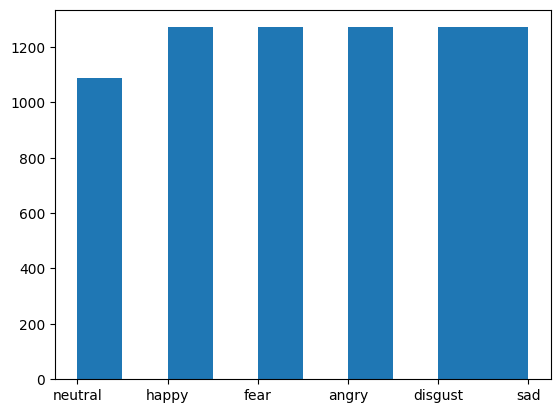

In [ ]:
plt.hist(Crema_df['Emotion'])

In [ ]:
Crema_df.shape

(7442, 2)

# A function to draw and listen to one waveform of each class

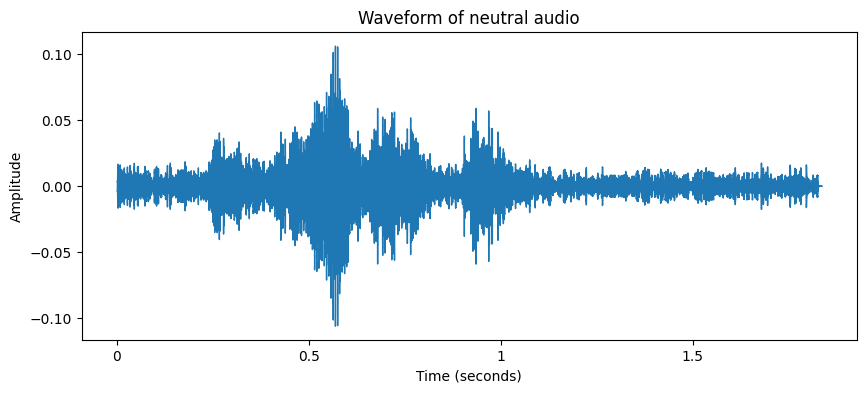

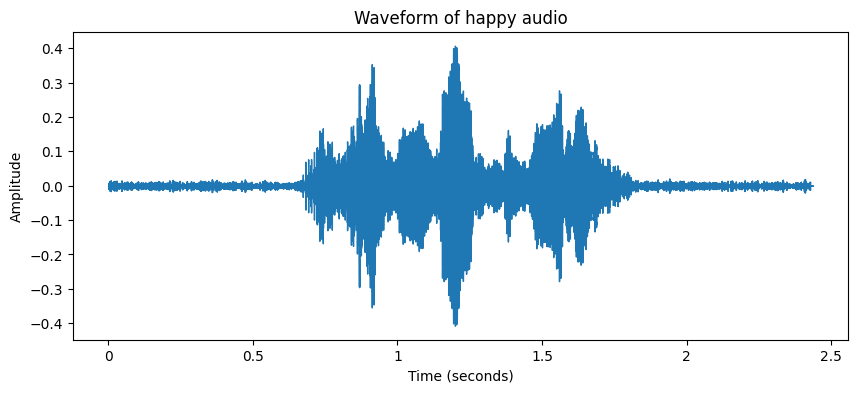

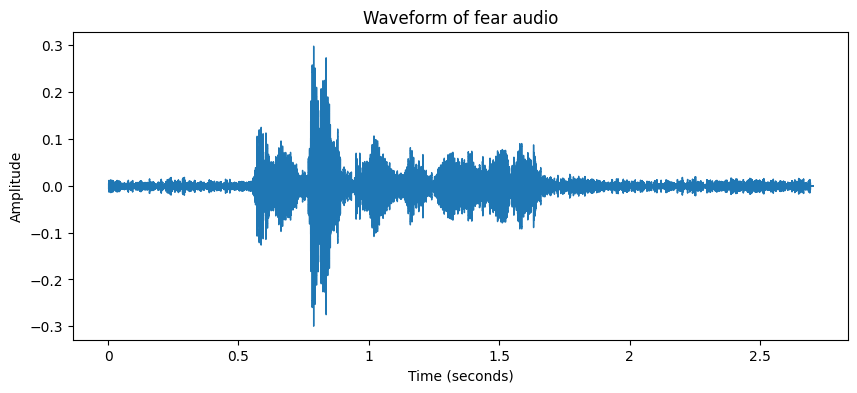

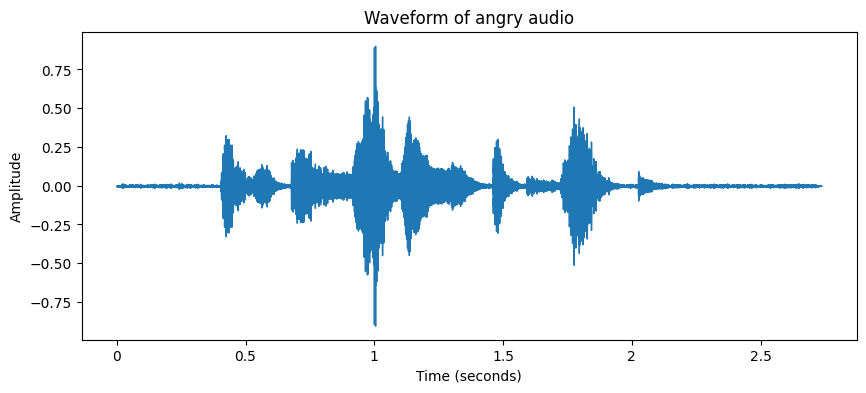

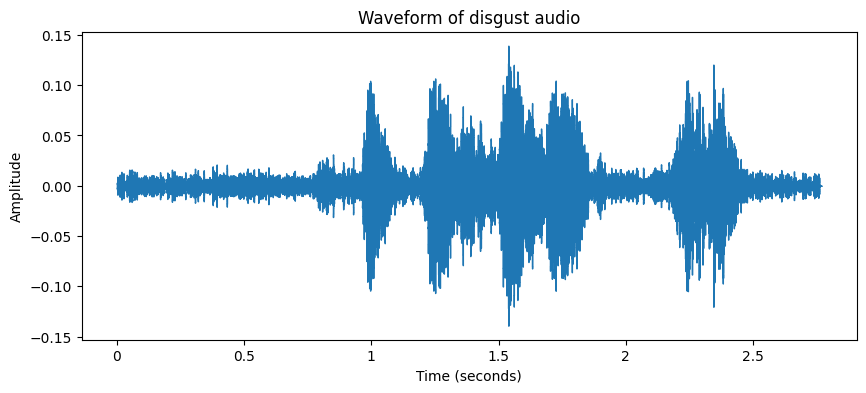

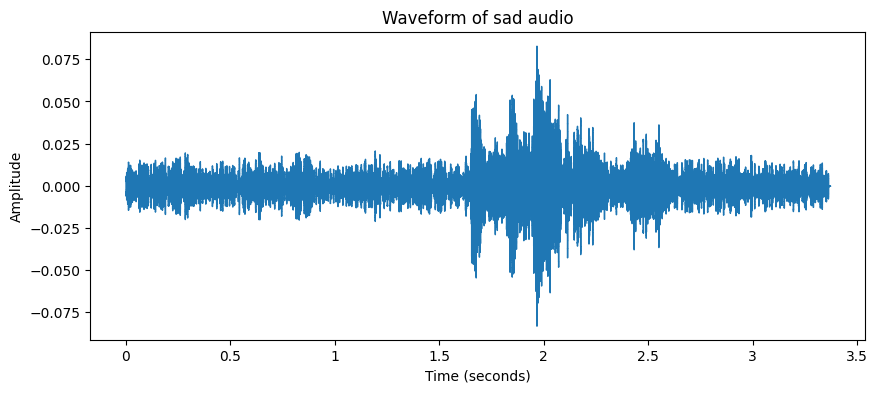

In [ ]:
for cls in Crema_df['Emotion'].unique():
  class_rows = Crema_df[Crema_df['Emotion'] == cls]
  for file_path in class_rows['File_Path']:
    audio_data, sr = librosa.load(file_path, sr=None)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio_data, sr=sr)
    plt.title(f'Waveform of {cls} audio')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.show()
    ipd.display(ipd.Audio(audio_data, rate=sr))
    break

# Feature Space Creation

In [ ]:
def zcr(data,sr,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

import numpy as np

def normalize_signal(signal, target_peak=1.0):
    # Calculate the maximum amplitude in the signal
    max_amplitude = np.max(np.abs(signal))

    # Calculate the scaling factor based on the target peak amplitude
    if max_amplitude == 0:
      max_amplitude=1
    scale_factor = target_peak / max_amplitude

    # Scale the signal by the calculated factor
    normalized_signal = signal * scale_factor

    return normalized_signal


def extract_features(data,sr,frame_length=2048,hop_length=512):
    result=np.array([])
    # data_mono = librosa.to_mono(data)
    # data_normalized = data_mono / max(abs(data_mono))
    data_normalized = normalize_signal(data)
    windowsize=int(sr*0.03)
    result=np.hstack((result,
                      zcr(data_normalized,sr,windowsize,windowsize),
                      rmse(data_normalized,frame_length,hop_length),
                      mfcc(data_normalized,sr,frame_length,hop_length)
                     ))
    return result

def add_noise(data,random=False,rate=0.035,threshold=0.075):
    if random:
        rate=np.random.random()*threshold
    noise=rate*np.random.uniform()*np.amax(data)
    augmented_data=data+noise*np.random.normal(size=data.shape[0])
    return augmented_data

def shifting(data,rate=1000):
    augmented_data=int(np.random.uniform(low=-5,high=5)*rate)
    augmented_data=np.roll(data,augmented_data)
    return augmented_data

def pitching(data,sr,pitch_factor=0.7,random=False):
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(y=data,sr=sr,n_steps=pitch_factor)

def streching(data,rate=0.8):
    return librosa.effects.time_stretch(data,rate)


def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data,sr)
    audio=np.array(aud)

    noised_audio=add_noise(data,random=True)
    aud2=extract_features(noised_audio,sr)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitching(data,sr,random=True)
    aud3=extract_features(pitched_audio,sr)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitching(data,sr,random=True)
    pitched_noised_audio=add_noise(pitched_audio1,random=True)
    aud4=extract_features(pitched_noised_audio,sr)
    audio=np.vstack((audio,aud4))

    return audio

In [ ]:
Y=[]
X=[[] for i in range(Crema_df.File_Path.shape[0])]

In [ ]:
len(X)

7442

In [ ]:
all_features=[]
count=0
for path,emotion,index in zip(Crema_df.File_Path,Crema_df.Emotion,range(Crema_df.File_Path.shape[0])):
    all_features=[]
    features=get_features(path)
    # print(len(features))
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        # print(i)
        # print(type(i))
        # all_features.extend(i)
        X[count].extend(i)
        # pass
    count+=1
    #print(emotion)
    Y.append(emotion)
#print(X[0])
print('Done')

0 audio has been processed
500 audio has been processed
1000 audio has been processed
1500 audio has been processed
2000 audio has been processed
2500 audio has been processed
3000 audio has been processed
3500 audio has been processed
4000 audio has been processed
4500 audio has been processed
5000 audio has been processed
5500 audio has been processed
6000 audio has been processed
6500 audio has been processed
7000 audio has been processed
Done


In [ ]:
Crema_df.shape

(7442, 2)

In [ ]:
len(X)

7442

In [ ]:
len(Y)

7442

In [ ]:
df=pd.DataFrame(X)
df['Emotion']=Y
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,9399,9400,9401,9402,9403,9404,9405,9406,9407,Emotion
0,0.033283,0.048411,0.045386,0.031770,0.021180,0.045386,0.030257,0.021180,0.039334,0.043873,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neutral
1,0.006051,0.033283,0.048411,0.090772,0.086233,0.074130,0.040847,0.030257,0.057489,0.090772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happy
2,0.018154,0.110439,0.394856,0.455371,0.393343,0.278366,0.046899,0.052950,0.066566,0.057489,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
3,0.231467,0.305598,0.196672,0.161876,0.080182,0.040847,0.062027,0.045386,0.025719,0.027231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
4,0.051437,0.057489,0.095310,0.048411,0.045386,0.031770,0.040847,0.046899,0.063540,0.024206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
5,0.016641,0.019667,0.030257,0.040847,0.034796,0.033283,0.028744,0.019667,0.019667,0.024206,...,-3.755653,-8.039515,-7.147338,-5.348928,-5.455729,-1.955563,-3.754994,-7.430313,-1.422995,sad
6,0.024206,0.049924,0.065053,0.046899,0.046899,0.040847,0.036309,0.093797,0.122542,0.055976,...,2.123616,2.659730,0.338313,-2.924572,-7.262484,-8.006713,-7.445565,-2.833103,-0.945157,disgust
7,0.167927,0.417549,0.470499,0.465961,0.487141,0.476551,0.455371,0.444781,0.490166,0.476551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
8,0.013616,0.031770,0.049924,0.065053,0.054463,0.059002,0.045386,0.027231,0.031770,0.036309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
9,0.012103,0.042360,0.034796,0.033283,0.030257,0.046899,0.036309,0.028744,0.025719,0.042360,...,3.981545,7.223068,-1.801883,-4.176072,-4.554123,-3.195390,-2.450913,-3.185890,-6.466912,disgust


In [ ]:
df.shape

(7442, 9409)

we need to add energy colomn

In [ ]:
energy=[]
for path,emotion,index in zip(Crema_df.File_Path,Crema_df.Emotion,range(Crema_df.File_Path.shape[0])):
  audio, sr = librosa.load(path, sr=None)
  # Preprocess the audio signal
  audio_mono = librosa.to_mono(audio)
  # Calculate the energy
  e = sum(audio_mono ** 2)
  energy.append(e)
df['energy']=energy

In [ ]:
df.shape

(7442, 9410)

In [ ]:
null_percentages = df.isnull().mean()*100
columns_to_drop = null_percentages[null_percentages>50].index
df_dropped = df.drop(columns_to_drop,axis=1)

In [ ]:
df=df_dropped.fillna(0)

In [ ]:
df.head(-5)

,0,1,2,3,4,5,6,7,8,9,...,7136,7137,7138,7139,7140,7141,7142,7143,Emotion,energy
0,0.033283,0.048411,0.045386,0.031770,0.021180,0.045386,0.030257,0.021180,0.039334,0.043873,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral,4.453418
1,0.006051,0.033283,0.048411,0.090772,0.086233,0.074130,0.040847,0.030257,0.057489,0.090772,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,happy,106.818918
2,0.018154,0.110439,0.394856,0.455371,0.393343,0.278366,0.046899,0.052950,0.066566,0.057489,...,-6.606388,0.126938,-10.999246,4.385688,-0.095064,-13.876718,9.570251,-16.412068,fear,24.793106
3,0.231467,0.305598,0.196672,0.161876,0.080182,0.040847,0.062027,0.045386,0.025719,0.027231,...,-119.842111,48.201721,25.325875,0.039127,-18.393260,-18.365514,-9.087462,-1.895075,angry,188.039086
4,0.051437,0.057489,0.095310,0.048411,0.045386,0.031770,0.040847,0.046899,0.063540,0.024206,...,-21.821623,-9.869623,-2.290702,-5.852867,9.324967,12.672128,0.935509,-11.055776,disgust,18.105766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7432,0.027231,0.033283,0.042360,0.031770,0.021180,0.016641,0.040847,0.025719,0.024206,0.043873,...,-88.361641,57.522813,-4.194974,-25.985965,-17.938837,-3.118157,0.216201,1.518242,happy,219.131202
7433,0.012103,0.055976,0.025719,0.033283,0.022693,0.037821,0.036309,0.068079,0.040847,0.051437,...,0.243570,0.298033,0.317700,0.369138,0.082809,0.096802,0.113246,0.115501,sad,3.706924
7434,0.019667,0.045386,0.040847,0.172466,0.403933,0.531014,0.384266,0.164902,0.074130,0.096823,...,0.725259,-0.219598,-6.297221,-3.734270,-2.105803,-3.854957,-4.940566,-2.967186,angry,220.554571
7435,0.021180,0.043873,0.060514,0.059002,0.051437,0.022693,0.018154,0.036309,0.024206,0.031770,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral,14.756182


In [ ]:
np.save('/content/drive/MyDrive/PRA4_DF/data.npy',  df.to_numpy())

In [ ]:
data = np.load('/content/drive/MyDrive/PRA4_DF/data.npy', allow_pickle=True)
df=pd.DataFrame(data)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,7136,7137,7138,7139,7140,7141,7142,7143,7144,7145
0,0.033283,0.048411,0.045386,0.03177,0.02118,0.045386,0.030257,0.02118,0.039334,0.043873,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,4.453418
1,0.006051,0.033283,0.048411,0.090772,0.086233,0.07413,0.040847,0.030257,0.057489,0.090772,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy,106.818918
2,0.018154,0.110439,0.394856,0.455371,0.393343,0.278366,0.046899,0.05295,0.066566,0.057489,...,-6.606388,0.126938,-10.999246,4.385688,-0.095064,-13.876718,9.570251,-16.412068,fear,24.793106
3,0.231467,0.305598,0.196672,0.161876,0.080182,0.040847,0.062027,0.045386,0.025719,0.027231,...,-119.842111,48.201721,25.325875,0.039127,-18.39326,-18.365514,-9.087462,-1.895075,angry,188.039086
4,0.051437,0.057489,0.09531,0.048411,0.045386,0.03177,0.040847,0.046899,0.06354,0.024206,...,-21.821623,-9.869623,-2.290702,-5.852867,9.324967,12.672128,0.935509,-11.055776,disgust,18.105766


# Feature Extraction

In [ ]:
label = df[7144]
X = df.drop(7144, axis=1)
label

0       neutral
1         happy
2          fear
3         angry
4       disgust
         ...   
7437       fear
7438       fear
7439      happy
7440        sad
7441        sad
Name: 7144, Length: 7442, dtype: object

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,7135,7136,7137,7138,7139,7140,7141,7142,7143,7145
0,0.033283,0.048411,0.045386,0.03177,0.02118,0.045386,0.030257,0.02118,0.039334,0.043873,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.453418
1,0.006051,0.033283,0.048411,0.090772,0.086233,0.07413,0.040847,0.030257,0.057489,0.090772,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106.818918
2,0.018154,0.110439,0.394856,0.455371,0.393343,0.278366,0.046899,0.05295,0.066566,0.057489,...,7.651491,-6.606388,0.126938,-10.999246,4.385688,-0.095064,-13.876718,9.570251,-16.412068,24.793106
3,0.231467,0.305598,0.196672,0.161876,0.080182,0.040847,0.062027,0.045386,0.025719,0.027231,...,1.804353,-119.842111,48.201721,25.325875,0.039127,-18.39326,-18.365514,-9.087462,-1.895075,188.039086
4,0.051437,0.057489,0.09531,0.048411,0.045386,0.03177,0.040847,0.046899,0.06354,0.024206,...,19.223425,-21.821623,-9.869623,-2.290702,-5.852867,9.324967,12.672128,0.935509,-11.055776,18.105766


In [ ]:
Y= label
Y.head()

0    neutral
1      happy
2       fear
3      angry
4    disgust
Name: 7144, dtype: object

# Label Encoding:

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels
encoded_labels = label_encoder.fit_transform(Y)

encoded_labels

array([4, 3, 2, ..., 3, 5, 5])

In [ ]:
y = pd.DataFrame(encoded_labels)

y.head()

,0
0,4
1,3
2,2
3,0
4,1


# Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score

# Assuming you have preprocessed data and labels as X and y

# Split the data into 70% training and validation, and 30% testing
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

# Further split the training and validation data into 95% training and 5% validation
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.05, random_state=42,stratify=y_trainval)


In [ ]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

In [ ]:
X_train.shape

(4948, 7145)

In [ ]:
y_train.shape

(4948, 1)

In [ ]:
X_train.head(-10)

,0,1,2,3,4,5,6,7,8,9,...,7135,7136,7137,7138,7139,7140,7141,7142,7143,7145
0,0.02118,0.043873,0.048411,0.040847,0.046899,0.03177,0.036309,0.03177,0.03177,0.015129,...,-8.26491,-12.080045,9.518659,4.217921,-3.385364,-1.292206,-10.990839,16.199918,-1.5864,35.964001
1,0.015129,0.057489,0.236006,0.364599,0.361573,0.096823,0.086233,0.08472,0.078669,0.083207,...,-0.936726,-161.244384,45.979748,38.96839,32.962714,21.156266,7.274983,-0.618472,-3.058322,7.459932
2,0.01059,0.022693,0.033283,0.049924,0.019667,0.055976,0.045386,0.036309,0.034796,0.048411,...,-7.402351,-86.500476,147.381989,-4.797049,58.847179,-6.89173,-1.507624,-29.849763,9.352522,5.268965
3,0.013616,0.102874,0.208775,0.452345,0.390318,0.425113,0.090772,0.049924,0.051437,0.055976,...,2.093962,-2.729647,-5.514491,-2.91915,0.160389,-8.022741,-8.180656,-6.878381,-4.574105,10.168179
4,0.027231,0.293495,0.367625,0.155825,0.087746,0.080182,0.072617,0.054463,0.054463,0.059002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,161.548357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4933,0.015129,0.04236,0.054463,0.04236,0.04236,0.034796,0.081694,0.406959,0.340393,0.051437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.917211
4934,0.066566,0.192133,0.172466,0.1059,0.083207,0.121029,0.173979,0.046899,0.034796,0.040847,...,-3.311923,-5.593165,1.133832,0.053946,-7.03678,-3.237282,-2.639133,-4.799815,-9.039049,480.971758
4935,0.019667,0.08472,0.16944,0.220877,0.278366,0.340393,0.423601,0.305598,0.066566,0.075643,...,1.801397,-264.157693,105.899838,23.655589,60.255567,4.410416,25.143661,-20.720658,10.307399,11.644333
4936,0.025719,0.02118,0.030257,0.046899,0.043873,0.11649,0.344932,0.261725,0.040847,0.04236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.63349


In [ ]:
y_train.head(-10)

,0
0,0
1,5
2,2
3,5
4,2
...,...
4933,5
4934,0
4935,1
4936,1


In [ ]:
!pip install alive_progress

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210079 sha256=3b27578ef77ef3f655f6a3acdf1faad935e4d920b6ab311b610c66ebe8d31a79
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset , DataLoader
import gc
from alive_progress import alive_bar

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class MyDataset(Dataset):
  def __init__(self , array , labels):
        self.array = array
        self.labels = labels

  def __getitem__(self,index):
    audio_features = self.array[index]
    return torch.tensor(audio_features).float() , torch.tensor(int(self.labels[index]))

  def __len__(self):
    return len(self.array)

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.cnn_layers = nn.Sequential(
            # Defining a 1D convolution layer
            nn.Conv1d(X_train.shape[1], 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            # Defining the second 1D convolution layer
            nn.Conv1d(64, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
            nn.Dropout(0.3),

            # Defining the third 1d convolution layer
            nn.Conv1d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            # Defining the fourth 1d convolution layer
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            # Defining the fifth 1d convolution layer
            nn.Conv1d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            # Flatten the last convolution layer
            nn.Flatten()
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 6),
            nn.Softmax()
        )

    # Defining the forward pass
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.linear_layers(x)
        return x

In [ ]:
class ModelNayrouz(nn.Module):
    def __init__(self):
        super(ModelNayrouz, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv1d(X_train.shape[1], 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            nn.Conv1d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            nn.Conv1d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            nn.Conv1d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            nn.Conv1d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            nn.Flatten()
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 6),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.linear_layers(x)
        return x


In [ ]:
def trainModel(model , dataloader , optimizer,current_epoch , loss_vec , acc_vec):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.train()
  loss_fun = nn.CrossEntropyLoss()
  total_loss = 0
  num_correct = 0
  with alive_bar(len(dataloader), force_tty=True) as bar:
    for data , label in dataloader:
      data = data.to(device)
      label = label.to(device)

      optimizer.zero_grad()
      output = model(data)

      loss = loss_fun(output, label)

      total_loss +=  loss.item()
      loss.backward()
      optimizer.step()


      pred = torch.argmax(output, 1)
      num_correct +=  pred.eq(label.data).cpu().sum()

      bar()

    acc = 100 * num_correct.to(torch.float32) / len(dataloader.dataset)
    acc_vec.append(float(acc))
    loss_vec.append(float(total_loss/len(dataloader)))

    print('Train Epoch : {} |  | loss = {}  train acc. = {}'.format(current_epoch , total_loss/len(dataloader) , acc))

In [ ]:
state = None
highestAcc=0

In [ ]:
def validateModel(model , dataloader , loss_vector,acc_vector):
  global state
  global highestAcc
  model.eval()
  loss_fun = nn.CrossEntropyLoss()
  total_loss = 0
  num_correct = 0
  with torch.no_grad():
    for (data , label) in dataloader:
      data = data.to(device)
      label = label.to(device)

      output = model(data)

      loss = loss_fun(output, label)

      total_loss = total_loss + loss.data.item()
      pred = torch.argmax(output, 1)
      num_correct +=  pred.eq(label.data).cpu().sum()
    val_loss = total_loss / len(dataloader)
    loss_vector.append(val_loss)

    acc = 100 * num_correct.to(torch.float32) / len(dataloader.dataset)
    if acc> highestAcc:
      highestAcc=acc
      state = model.cpu().state_dict().copy()

    acc_vector.append(float(acc))

    print('Validation set Average loss : {}  , Acc. : | {} / {} | with {} %'.format(val_loss, num_correct, len(dataloader.dataset), acc ))

In [ ]:
def testModel(model , dataloader):

  model.eval()
  pred_vec , labels_vec = [] , []

  num_correct = 0
  with torch.no_grad():
    for (data , label) in dataloader:
      gc.collect()
      torch.cuda.empty_cache()

      data = data.to(device)
      label = label.to(device)

      output = model(data)

      # get index of max log prob.
      pred = torch.argmax(output, 1)
      pred_vec += pred.cpu()
      labels_vec+= label.data
      num_correct +=  pred.eq(label.data).cpu().sum()


  acc = 100 * num_correct.to(torch.float32) / len(dataloader.dataset)


  print('Test set Average Accuracy : | {} / {} | with {} %'.format(num_correct, len(dataloader.dataset), acc ))
  return labels_vec , pred_vec

In [ ]:
def saveModel(model , file_name):
    torch.save(model.state_dict() , file_name)

def loadModel(file_name , time_domain = True):
    checkpoint = torch.load(file_name)
    model = Model().to(device)
    model.load_state_dict(checkpoint)

def graphs_train_val_acc(train_acc,val_acc):
    plt.plot(val_acc, label='validation accuracy')
    plt.plot(train_acc, label='train accuracy')
    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

def graphs_train_val_loss(train_loss , val_loss):
    plt.plot(val_loss, label='validation Loss')
    plt.plot(train_loss, label='train Loss')
    plt.title('Training history')
    plt.ylabel('Accuracy Loss')
    plt.xlabel('Epoch')
    plt.legend()

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(4948, 7145, 1, 1)

In [ ]:
X_train = np.squeeze(X_train, axis=2)
X_val = np.squeeze(X_val, axis=2)
X_test = np.squeeze(X_test, axis=2)
X_train.shape

(4948, 7145, 1)

In [ ]:
X_train = X_train.astype(np.float16)
X_val = X_val.astype(np.float16)
X_test = X_test.astype(np.float16)
X_train.shape

(4948, 7145, 1)

In [ ]:
X_train.shape

(4948, 7145, 1, 1)

In [ ]:
X_test.dtype

dtype('float16')

In [ ]:
X_test.shape

(2233, 7145, 1)

In [ ]:
y_test.shape

(2233, 1)

In [ ]:
train_dataset = MyDataset(X_train , y_train.to_numpy())
validation_dataset = MyDataset(X_val , y_val.to_numpy())
test_dataset = MyDataset(X_test , y_test.to_numpy())

In [ ]:
print(train_dataset)

In [ ]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset , batch_size = BATCH_SIZE)
validation_loader = DataLoader(validation_dataset , batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset , batch_size = BATCH_SIZE)

In [ ]:
model = Model().to(device)
EPOCHS = 500
learning_rate = 0.00005
weight_decay=0.0001
optimizer = torch.optim.Adam(model.parameters() , learning_rate )
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer , patience=5 , threshold=1e-4)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
val_loss_vec , val_acc_vec = [] , []
train_loss_vec , train_acc_vec = [] , []
lr_vec = []

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inputs, labels = inputs.to(device), labels.to(device)

In [ ]:
for e in range(EPOCHS):
    gc.collect()
    torch.cuda.empty_cache()
    lr_vec.append(get_lr(optimizer))

    trainModel(model , train_loader , optimizer , e+1 , train_loss_vec  ,train_acc_vec)
    gc.collect()
    torch.cuda.empty_cache()

    validateModel(model , validation_loader , val_loss_vec  ,val_acc_vec )
    sheduler.step(val_loss_vec[e])
    print()
    if e%10==0:
          saveModel(model , '/content/drive/MyDrive/PRA4/Model_checkpoint_{}.pth'.format(e))

on 310: Train Epoch : 1 |  | loss = 1.7618644710510007  train acc. = 24.85852813720703
|████████████████████████████████████████| 310/310 [100%] in 2.7s (114.82/s)    
Validation set Average loss : 1.7276148585712208  , Acc. : | 76 / 261 | with 29.1187744140625 %

on 310: Train Epoch : 2 |  | loss = 1.7180284384758242  train acc. = 29.870655059814453
|████████████████████████████████████████| 310/310 [100%] in 2.2s (143.64/s)    
Validation set Average loss : 1.7015949838301714  , Acc. : | 85 / 261 | with 32.56705093383789 %

on 310: Train Epoch : 3 |  | loss = 1.6875212011798735  train acc. = 33.811641693115234
|████████████████████████████████████████| 310/310 [100%] in 2.1s (147.12/s)    
Validation set Average loss : 1.6698297823176664  , Acc. : | 91 / 261 | with 34.865901947021484 %

on 310: Train Epoch : 4 |  | loss = 1.6693257054974955  train acc. = 35.89329147338867
|████████████████████████████████████████| 310/310 [100%] in 2.1s (149.32/s)    
Validation set Average loss : 1.

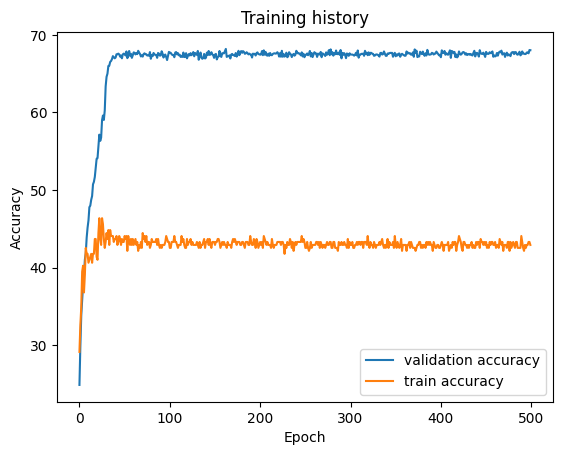

In [ ]:
graphs_train_val_acc(val_acc_vec,train_acc_vec)

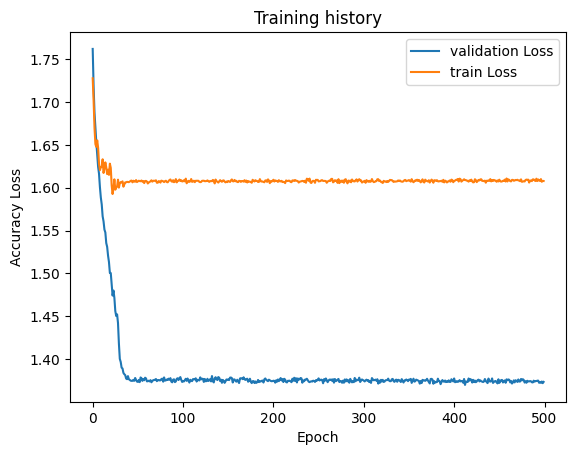

In [ ]:
graphs_train_val_loss(val_loss_vec ,train_loss_vec )

In [ ]:
from sklearn.metrics import f1_score
model.load_state_dict(state)
y_true , y_pred = testModel(model , test_loader)

acc_time = accuracy_score(y_test, y_pred)
f_score_time = f1_score(y_test, y_pred,average='micro')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test set Average Accuracy : | 838 / 2233 | with 37.52798843383789 %


In [ ]:
f_score_time

0.3752798925212718

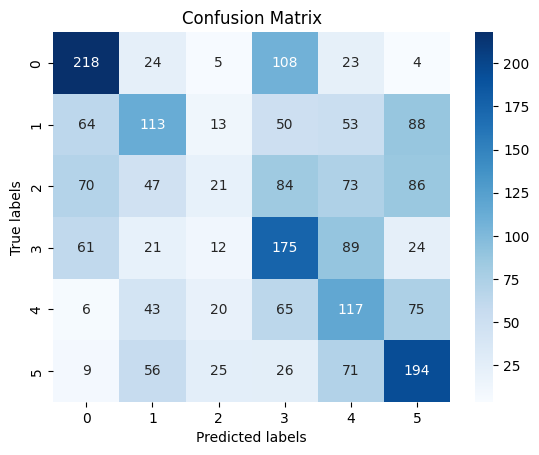

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [ ]:
model = ModelNayrouz().to(device)
EPOCHS = 200
learning_rate = 0.00005
weight_decay=0.0001
optimizer = torch.optim.Adam(model.parameters() , learning_rate )
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer , patience=5 , threshold=1e-4)

In [ ]:
for e in range(EPOCHS):
    gc.collect()
    torch.cuda.empty_cache()
    lr_vec.append(get_lr(optimizer))

    trainModel(model , train_loader , optimizer , e+1 , train_loss_vec  ,train_acc_vec)
    gc.collect()
    torch.cuda.empty_cache()

    validateModel(model , validation_loader , val_loss_vec  ,val_acc_vec )
    sheduler.step(val_loss_vec[e])
    print()
    if e%10==0:
          saveModel(model , '/content/drive/MyDrive/PRA4/Model_checkpoint_{}.pth'.format(e))

on 0: /usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
        input = module(input)


on 310: Train Epoch : 1 |  | loss = 1.7952196694189502  train acc. = 17.68391227722168
|████████████████████████████████████████| 310/310 [100%] in 3.4s (90.71/s)     
Validation set Average loss : 1.7880909092286055  , Acc. : | 50 / 261 | with 19.157087326049805 %

on 310: Train Epoch : 2 |  | loss = 1.7935704381235185  train acc. = 17.70412254333496
|████████████████████████████████████████| 310/310 [100%] in 3.3s (93.75/s)     
Validation set Average loss : 1.7786194436690386  , Acc. : | 57 / 261 | with 21.839080810546875 %

on 310: Train Epoch : 3 |  | loss = 1.785202846988555  train acc. = 19.199676513671875
|████████████████████████████████████████| 310/310 [100%] in 3.6s (86.43/s)     
Validation set Average loss : 1.7759535452898811  , Acc. : | 55 / 261 | with 21.072797775268555 %

on 310: Train Epoch : 4 |  | loss = 1.774747202473302  train acc. = 21.503637313842773
|████████████████████████████████████████| 310/310 [100%] in 3.6s (86.39/s)     
Validation set Average loss : 1

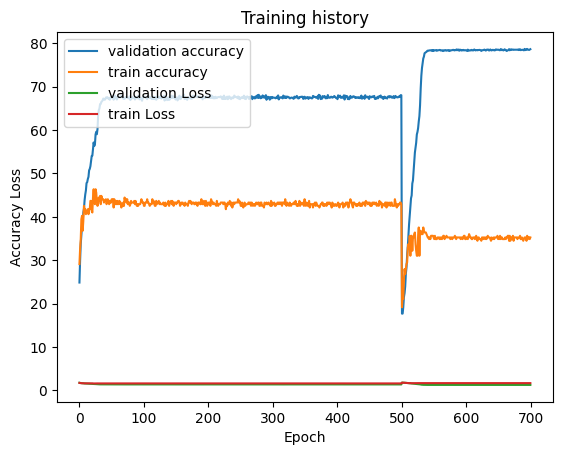

In [ ]:
graphs_train_val_acc(val_acc_vec,train_acc_vec)
graphs_train_val_loss(val_loss_vec ,train_loss_vec )

In [ ]:
from sklearn.metrics import f1_score
#model.load_state_dict(state)
y_true , y_pred = testModel(model , test_loader)

acc_time = accuracy_score(y_test, y_pred)
f_score_time = f1_score(y_test, y_pred,average='micro')

Test set Average Accuracy : | 421 / 2233 | with 18.853559494018555 %


In [ ]:
f_score_time

0.18853560232870575

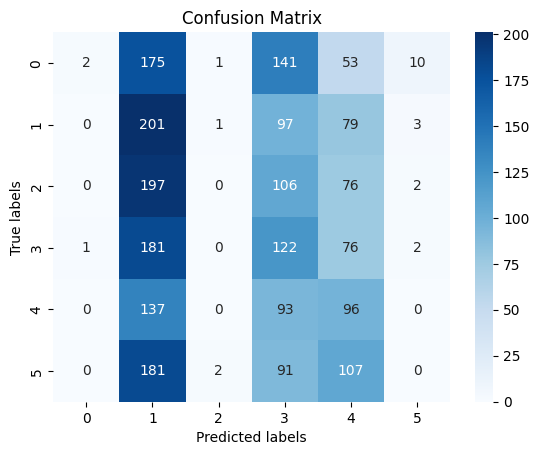

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()